<a href="https://colab.research.google.com/github/johnjoel2001/XAI-Project/blob/main/The_Price_of_a_Home%E2%80%A6_and_the_Cost_of_Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Price of a Home… and the Cost of Bias**

### Problem Statement: **Beyond Accuracy: Auditing Fairness in Housing Price Predictions**

- Machine learning models are becoming powerful decision-makers, from predicting housing prices to approving loans and screening job applicants.

- But behind every dataset are real people, and behind every prediction is the potential for unintended bias.

In this project, I ask an important question: **Can a model be accurate, yet still unfair?**

- I explore this using the **Boston Housing dataset**, which includes a sensitive feature `B`, a derived variable related to the racial composition of a neighborhood.

- While `B` might contribute to better prediction accuracy, it also raises ethical concerns.

- Our goal shouldn't just be to predict house prices well, it should be to build models that are both smart and fair.

- By using the **Dalex** library, we move beyond traditional metrics like RMSE and R², and dive into fairness evaluation.

- We investigate whether our models treat different groups equitably, and whether any bias exists in the predictions.

**To put it short:**

- We are not only asking “**How well does this model perform?**”  

- We are also asking, “**Whom does this model serve and whom might it harm?**”



**Dalex**

- Dalex stands for Descriptive Machine Learning Explanations.

- It is a Python library used to understand, explain, and debug machine learning models.

- In simple terms, Dalex helps you see how our model is making decisions—and whether it's being fair, accurate, or biased.

- We will be making use of this library to evaluate fairness.

In [1]:
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "XAI-Project"
git_path = 'https://github.com/johnjoel2001/XAI-Project.git' #Change to your path
!git clone "{git_path}"

Cloning into 'XAI-Project'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 13.28 KiB | 4.43 MiB/s, done.


In [ ]:
# Installing dalex

!pip install dalex -q  # Tool for Fairness Evaluation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Importing Dependecies

import numpy as np  # For Numerical Operations
import matplotlib.pyplot as plt  # For Basic Plotting
import pandas as pd  # For Handling Data in Tables
import plotly.express as px  # For Interactive plots
from statsmodels.graphics.gofplots import qqplot  # For Q-Q plots (normality check)
import seaborn as sns  # For Advanced Statistical plots
%matplotlib inline


# Models

from sklearn.model_selection import cross_val_score, train_test_split  # For Splitting data & Cross-validation
from sklearn.linear_model import LinearRegression  # For Linear Regression
from sklearn.metrics import mean_squared_error  # For Measuring Prediction error
from sklearn.ensemble import RandomForestRegressor  # For Random Forest Regression
from sklearn.tree import DecisionTreeRegressor  # For Decision Tree Regression
from xgboost import XGBRFRegressor  # For Boosted Random Forest Regression using XGBoost

# For Fairness Evaluation

import dalex as dx

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Reading the Dataset

df = pd.read_csv('/content/HousingData.csv')

In [ ]:
df.head()   # Displaying the first five rows of the dataset

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [ ]:
# Checking the shape of the dataset

df.shape

(506, 14)

In [ ]:
df.info()  # Basic info of our dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


**We will see what each feature in the dataset signifies**:


| Column Name | Description |
|-------------|-------------|
| **CRIM**    | Crime rate per capita in the neighborhood. |
| **ZN**      | Percentage of residential land zoned for large lots (over 25,000 sq.ft.). |
| **INDUS**   | Proportion of land used for non-retail business (industrial areas). |
| **CHAS**    | Is the house near the Charles River? (1 = Yes, 0 = No) |
| **NOX**     | Air pollution level (nitric oxides concentration). |
| **RM**      | Average number of rooms per house. |
| **AGE**     | Percentage of homes built before 1940 (older homes). |
| **DIS**     | Distance to major employment centers (weighted). |
| **RAD**     | Index of accessibility to radial highways. |
| **TAX**     | Property tax rate per $10,000 of property value. |
| **PTRATIO** | Ratio of students to teachers in nearby schools. |
| **B**       | A formula: `1000(Bk - 0.63)^2` (Bk = proportion of Black residents). |
| **LSTAT**   | Percentage of people in the area with lower income status. |




**Target Variable:**

Median value of homes (in $1000s)

**A note on the `B` Feature**

 - The B feature is calculated using the formula:
`B = 1000(Bk - 0.63)^2`, where Bk is the proportion of Black residents in an area.

 - This feature was added long ago, but today, it doesn’t make sense to use it.

 - It doesn’t clearly explain anything about housing prices, and more importantly, it can bring in racial bias to your model.



**Bias Testing**

 - I am intentionally keeping the feature `B` in the dataset for one important reason:

      - To analyze bias and fairness using different models with the Dalex library.
      
      - By including B, we can test whether any model is making predictions unfairly based on race-related information.
      
      - This helps us identify if bias is present and take action to mitigate it.

In [ ]:
# Checking for Null Values
df.isnull().sum()

,0
CRIM,20
ZN,20
INDUS,20
CHAS,20
NOX,0
RM,0
AGE,20
DIS,0
RAD,0
TAX,0


In [ ]:
# Imputation

# Filling missing values in numerical columns using the mean
df["CRIM"].fillna(df["CRIM"].mean(), inplace=True)
df["ZN"].fillna(df["ZN"].mean(), inplace=True)
df["INDUS"].fillna(df["INDUS"].mean(), inplace=True)
df["AGE"].fillna(df["AGE"].mean(), inplace=True)
df["LSTAT"].fillna(df["LSTAT"].mean(), inplace=True)

# Filling missing values in the binary column 'CHAS' using the mode
df["CHAS"].fillna(df["CHAS"].mode()[0], inplace=True)



In [ ]:
# Checking for Null Values after Mode Imputation
df.isnull().sum()

,0
CRIM,0
ZN,0
INDUS,0
CHAS,0
NOX,0
RM,0
AGE,0
DIS,0
RAD,0
TAX,0


In [ ]:
# Checking the number of unique values in each column

df.nunique()

,0
CRIM,485
ZN,27
INDUS,77
CHAS,2
NOX,81
RM,446
AGE,349
DIS,412
RAD,9
TAX,66


<Axes: >

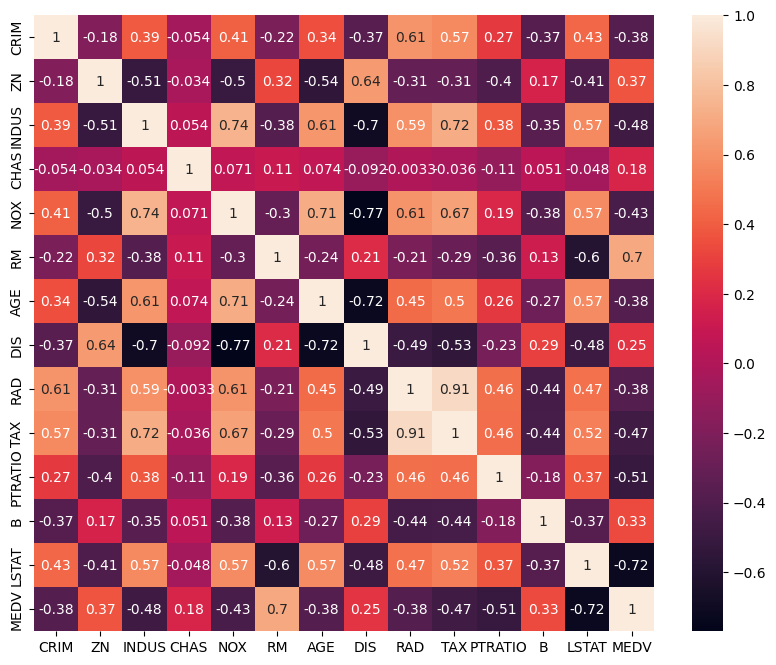

In [ ]:
# Correlation Plot

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot = True)

**Feedback on `B` Feature in terms of correlation with other features:**



**Correlation with `MEDV` (target):**

The correlation between `B` and `MEDV` is around +0.33, which is weak to moderate. This suggests that B is not a strong predictor of house prices.

**Correlation with other features:**

`B` is weakly correlated (mostly < 0.3 or negative) with most other variables like:

`DIS:` -0.44

`RAD`: +0.18

`LSTAT`: +0.33

**Fairness Consideration**

 - Since `B` encodes racial information, using it in modeling can introduce unintended racial bias.

 - Even though the correlation is modest, its presence could skew the Machine Learning model in subtle ways.




Text(0.5, 0, 'B value')

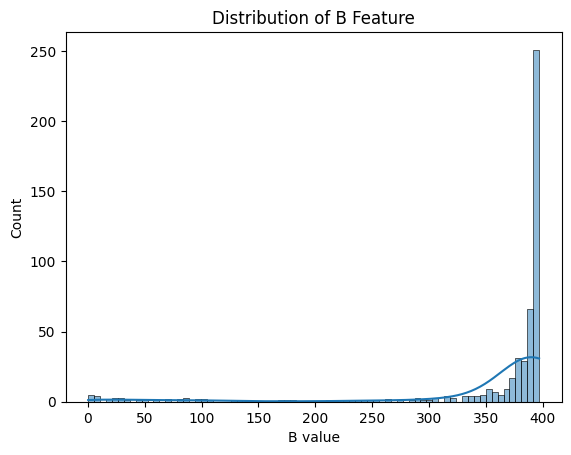

In [ ]:
# Plotting  the distribution of the 'B' feature using a histogram with a KDE (smooth curve)
sns.histplot(df["B"], kde=True)

# Setting the title of the plot
plt.title("Distribution of B Feature")

plt.xlabel("B value")


**Takeaways**

**1. Most values are near 400**

- The majority of the data points are clustered around 396 to 400.
- This means that for most neighborhoods, the formula `1000(Bk - 0.63)^2` gives a high value suggesting a very low proportion of Black residents (`Bk` close to 1).

**2. Very few values are low**

- Only a small number of areas have `B` values closer to 0 or in the lower range.

- These represent neighborhoods with higher Black populations.

**3. Highly skewed distribution**

  - The plot is heavily right-skewed.
  - This shows the data is imbalanced in terms of representation.



Text(0, 0.5, 'Median Value of Homes')

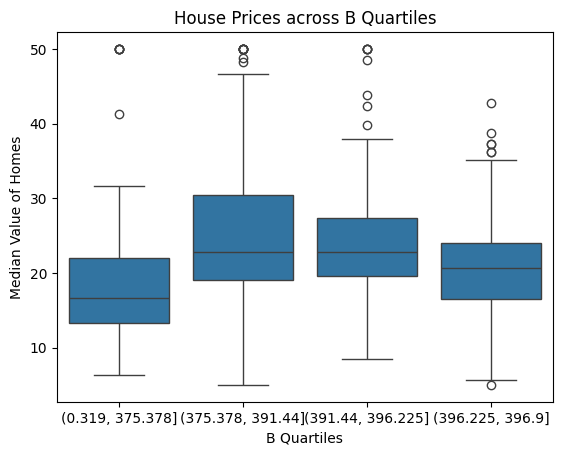

In [ ]:
# Plotting a boxplot to see how house prices vary across different ranges of the 'B' feature
sns.boxplot(x=pd.qcut(df["B"], q=4), y=df["MEDV"])

# Seting t the title of the plot
plt.title("House Prices across B Quartiles")
plt.xlabel("B Quartiles")
plt.ylabel("Median Value of Homes")


**Takeaways**

**1. Higher house prices are seen in middle quartiles**

- The 2nd and 3rd quartiles (`B` between ~375 and ~396) show higher median house prices.

**2. Lowest `B` values → Lower home prices**

- The first quartile (lowest `B` values) shows the lowest median and wider spread in prices.

- This suggests that areas with higher proportions of Black residents (since `B` is low) tend to have lower home prices.

**3. Highest `B` quartile doesn’t guarantee highest prices**

- The 4th quartile (very high `B` values) doesn’t show the highest prices, meaning there's no clear increasing trend.

**Implication for Fairness:**

- This suggests there may be a link between the racial composition (via the B feature) and house prices which raises a red flag for fairness in predictive modeling.

- It's important to analyze this further using fairness tools like Dalex.

Text(0.5, 1.0, 'Relationship between B and MEDV')

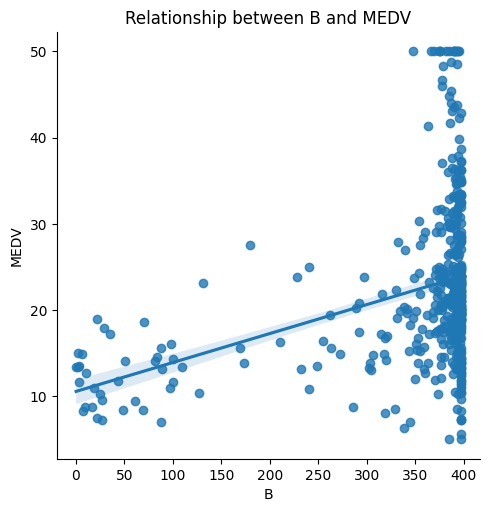

In [ ]:
# Plotting a scatter plot with a linear regression line to show the relationship between B and house prices
sns.lmplot(x="B", y="MEDV", data=df)

plt.title("Relationship between B and MEDV")


**Takeaways**

1) There's a small upward slope, meaning that as `B` increases, house prices (`MEDV`) tend to go up slightly.

2) Using `B` in a model without questioning what it represents can lead to bias.

3) This plot is useful for understanding that even weak trends in sensitive features should be audited before trusting model outputs

In [ ]:
# Applying MinMaxScaler to  bring the values in a particular arrange ( i.e. here 0 to 1)

from sklearn.preprocessing import MinMaxScaler

# Creating a MinMaxScaler instance
scaler = MinMaxScaler()

# Selecting numeric columns to scale (excluding target variable 'MEDV')
features_to_scale = df.drop("MEDV", axis=1)

# Applying Min-Max scaling to the selected features
scaled_features = scaler.fit_transform(features_to_scale)

# Converting the result back into a DataFrame (keep original column names)
scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale.columns)

# Adding the target column 'MEDV' back to the scaled DataFrame
scaled_df["MEDV"] = df["MEDV"]


print(scaled_df.head())


       CRIM    ZN     INDUS  CHAS       NOX        RM       AGE       DIS  \
0  0.000000  0.18  0.067815   0.0  0.314815  0.577505  0.641607  0.269203   
1  0.000236  0.00  0.242302   0.0  0.172840  0.547998  0.782698  0.348962   
2  0.000236  0.00  0.242302   0.0  0.172840  0.694386  0.599382  0.348962   
3  0.000293  0.00  0.063050   0.0  0.150206  0.658555  0.441813  0.448545   
4  0.000705  0.00  0.063050   0.0  0.150206  0.687105  0.528321  0.448545   

        RAD       TAX   PTRATIO         B     LSTAT  MEDV  
0  0.000000  0.208015  0.287234  1.000000  0.089680  24.0  
1  0.043478  0.104962  0.553191  1.000000  0.204470  21.6  
2  0.043478  0.104962  0.553191  0.989737  0.063466  34.7  
3  0.086957  0.066794  0.648936  0.994276  0.033389  33.4  
4  0.086957  0.066794  0.648936  1.000000  0.303130  36.2  


In [ ]:
# Separating the input features (X) and the target variable (y) for model training
X = scaled_df.drop(columns=['MEDV'], axis=1)
y=scaled_df['MEDV']

In [ ]:
# Performing Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8,random_state=42)

In [ ]:
# Linear Regression

# Creating a Linear Regression model object
model_lr = LinearRegression()

# Training the model using the training data
model_lr.fit(X_train, y_train)

# Making predictions on the test data
pred_tst = model_lr.predict(X_test)

# Calculating the Root Mean Squared Error (RMSE) as the evaluation metric
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_tst))

# Printing the RMSE value
print(rmse_lr)

5.004463337007718


In [ ]:
# Random Forest

# Creating a Random Forest Regressor model instance
model_rf = RandomForestRegressor()

# Training the Random Forest model using the training data
model_rf.fit(X_train, y_train)

# Making predictions on the test data
pred_rf = model_rf.predict(X_test)

# Calculating the Root Mean Squared Error (RMSE) for evaluation
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))

# Printing the RMSE value
print(rmse_rf)


3.1513124841165814


In [ ]:
# Decision Tree Regression

# Creating a Decision Tree Regressor model instance
model_dt = DecisionTreeRegressor()

# Traiing the model using the training data
model_dt.fit(X_train, y_train)

# Making predictions on the test data
pred_dt = model_dt.predict(X_test)

# Calculating the Root Mean Squared Error (RMSE) for evaluation
rmse_dt = np.sqrt(mean_squared_error(y_test, pred_dt))

# Printing the RMSE value
print(rmse_dt)


4.714547781528332


In [ ]:
# XGBoost Regression

# Creating an XGBRFRegressor model object with specific parameters
model_xgb = XGBRFRegressor(max_depth=8, n_estimators=10)

# Training the XGBoost model on the training data
model_xgb.fit(X_train, y_train)

# Making predictions on the test data
pred_xgb = model_xgb.predict(X_test)

# Calculating the Root Mean Squared Error (RMSE) to evaluate the model
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))

# Printing the RMSE value
print(rmse_xgb)


2.787804466219277


In [ ]:
# Creating a DataFrame to compare the performance of different models
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'RMSE': [rmse_lr, rmse_dt, rmse_rf, rmse_xgb]
})

# Display the comparison table
models

,Model,RMSE
0,Linear Regression,5.004463
1,Decision Tree,4.714548
2,Random Forest,3.151312
3,XGBoost,2.787804


**Model Performance Summary**

**1) XGBoost performed the best**
- Lowest RMSE (2.79) -> most accurate predictions.

**2) Random Forest also did well**
- RMSE is 3.04 which is also good.

**3) Linear Regression and Decision Tree performed worse**
- Higher RMSE (~5.00) -> less accurate compared to ensemble models.



# **Fairness Evaluation**

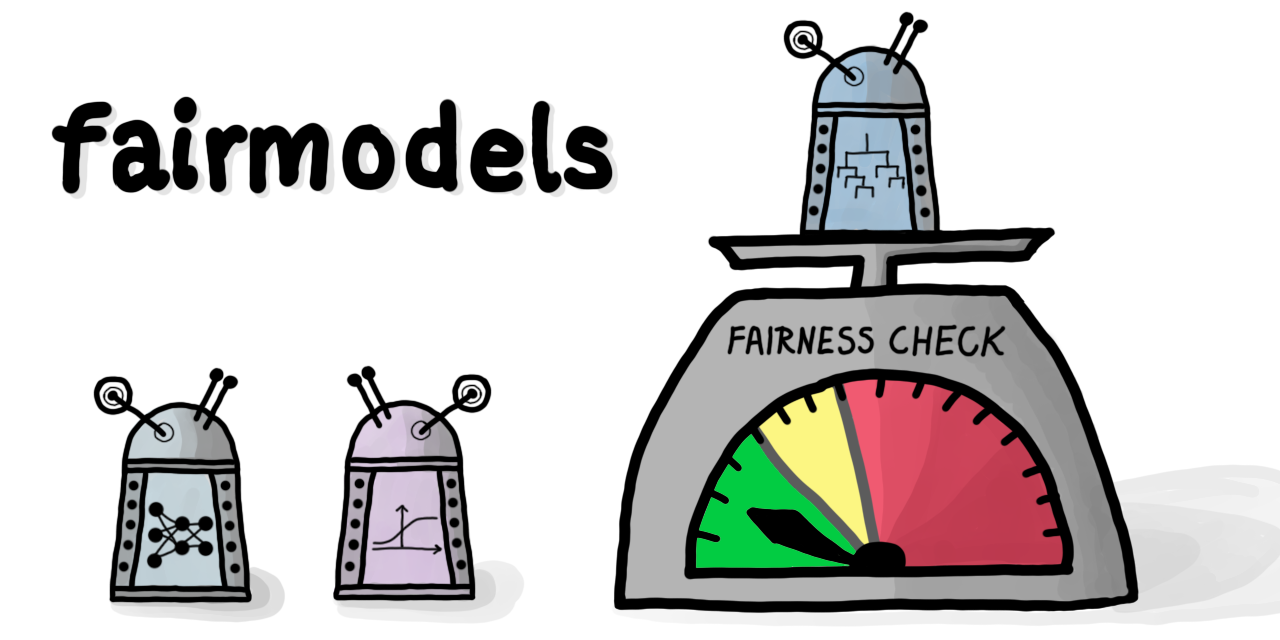

Image Source: [link text](https://github.com/ModelOriented/fairmodels)

In [ ]:
# Creating a Dalex explainer for the Linear Regression model
exp = dx.Explainer(model_lr, X_test, y_test, verbose=False)

# Creating a Dalex explainer for the Decision Tree model
exp2 = dx.Explainer(model_dt, X_test, y_test, verbose=False)

# Creating a Dalex explainer for the Random Forest model
exp3 = dx.Explainer(model_rf, X_test, y_test, verbose=False)

# Creating a Dalex explainer for the XGBoost model
exp4 = dx.Explainer(model_xgb, X_test, y_test, verbose=False)


In [ ]:
# Getting performance results for each explainer
mp1 = exp.model_performance().result
mp2 = exp2.model_performance().result
mp3 = exp3.model_performance().result
mp4 = exp4.model_performance().result

# Concatenating all results into a single DataFrame
all_results = pd.concat([mp1, mp2, mp3, mp4])

# Displaying the combined results
print(all_results)


                             mse      rmse        r2       mae       mad
LinearRegression       25.044653  5.004463  0.658484  3.156311  2.251832
DecisionTreeRegressor  22.226961  4.714548  0.696907  2.763725  2.050000
RandomForestRegressor   9.930770  3.151312  0.864581  2.152627  1.694000
XGBRFRegressor          7.771854  2.787804  0.894021  2.122171  1.700132


**Fairness Evaluation Using Dalex**

- We have now evaluated model performance using standard metrics like MSE, RMSE, R², MAE, and MAD.

- Now, it is important to ensure that our models are fair especially when sensitive features (like race, gender, etc.) might influence the outcome.

- With the help of **Dalex** explainers, we can assess fairness across different models.

- To do this, we check whether the model meets the following fairness conditions.


**Fairness Conditions (Independence Criteria)**

Let:
- `A` = Protected attribute (e.g., race, gender)
- `Y` = True label (actual house price)
- `R` = Model prediction

We evaluate these three conditions:

1. **Independence**: `R ⊥ A`  
   The prediction `R` should not depend on the protected group `A`.  
   (e.g., House price predictions should not vary just because the neighborhood has more or fewer people of a particular race.)

2. **Separation**: `R ⊥ A | Y`  
   Given the true label `Y`, the prediction `R` should be independent of the protected attribute.  
   (e.g., Among houses of the same actual value, the prediction should be the same regardless of the protected group.)

3. **Sufficiency**: `Y ⊥ A | R`  
   Given the prediction `R`, the true value `Y` should not depend on the protected group `A`.  
   (e.g., For homes predicted to cost $500k, their actual value shouldn’t differ by race.)


**How Dalex Checks Fairness**

To assess these independence criteria, **Dalex** uses a method called: **Direct Density Ratio Estimation (DDRE)**

This method works as follows:

- Instead of calculating full probability distributions (which is hard), it estimates how much more likely a value is under one group compared to another.

- It then directly compares the density (distribution) of the predictions between groups to see if there's a statistically significant difference.

- This makes it easier to detect hidden bias in models, even if traditional metrics look fine.

This approach is based on the paper by Steinberg et al. (2020): **Fairness in AI: The Case for Causal Path-Specific Analysis**  
[Read the paper here](https://arxiv.org/pdf/2001.06089)


**Why This Matters**

- Using DDRE, we can quantify how fair or unfair a model is, and make adjustments if necessary.

- Like dropping biased features, reweighting data, or applying fairness-aware algorithms.

- Fairness checks are critical, especially when working with sensitive data like housing, healthcare, education, or finance, where biased predictions can have real-life consequences.


In [ ]:
# Now let us define the protected group based on the 'B' feature
# If B >= 0.5, label as 'majority_black', otherwise label as 'else'

protected = np.where(X_test.B >= 0.5, 'majority_black', "else")

# Defining the privileged group as 'else'
privileged = 'else'

# Checking fairness of the Linear Regression model
fobject = exp.model_fairness(protected, privileged)


In [ ]:
fobject.fairness_check()

Bias detected in 1 metrics: independence

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'else'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                independence  separation  sufficiency
subgroup                                             
majority_black      2.059186    1.128906     0.879569


**Fairness Check Result for Linear Regression Model**

- The model is not fair.

- This is because one of the fairness metrics: **independence** is outside the acceptable range.

- The independence ratio for the `majority_black` group is 2.06, which is much higher than the allowed range of 0.8 to 1.25.

**Inferences**

- The model’s predictions depend too much on whether the neighborhood has a higher proportion of black residents.

- This suggests a potential racial bias in predictions — which is unfair and problematic.

- The other two metrics (**separation** and **sufficiency**) are closer to the acceptable range, but independence fails badly.



In [ ]:
# Checking fairness of the Decision Tree model
fobject2 = exp2.model_fairness(protected, privileged)

In [ ]:
fobject2.fairness_check()

No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, based on 'else'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                independence  separation  sufficiency
subgroup                                             
majority_black       1.09977    0.880704     0.978238


**Fairness Check Result for Decision Tree Model**
- No bias was detected.

- All values fall within the acceptable fairness range of 0.8 to 1.25.

- The model is fair based on the three fairness criteria: **Independence**, **Separation** and **Sufficiency**

**Inferences**

- The Decision Tree Model treats the protected group fairly, according to the test.

- It suggests that the Decision Tree model is a better choice from a fairness standpoint compared to Linear Regression (which failed the independence test earlier).

In [ ]:
# Checking fairness of the Random Forest model
fobject3 = exp3.model_fairness(protected, privileged)

In [ ]:
fobject3.fairness_check()

No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, based on 'else'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                independence  separation  sufficiency
subgroup                                             
majority_black      1.164876    0.800174     0.880498


**Fairness Check Result for Random Forest Model**

- No bias was detected!

- The model is considered fair because all three fairness metrics are within the acceptable range of 0.8 to 1.25.

**Inferences**

- The Random Forest model treats the `majority_black` group fairly across all three fairness tests.

- The metrics are very close to ideal values, showing minimal bias.

- Overall, this model is both accurate (least rmse among all models) and fair, making it a good candidate for deployment.



In [ ]:
# Checking fairness of the XGBoost model
fobject4 = exp4.model_fairness(protected, privileged)

In [ ]:
fobject4.fairness_check()

Bias detected in 1 metrics: separation

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'else'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                independence  separation  sufficiency
subgroup                                             
majority_black      1.190665    0.785167     0.874306


**Fairness Check Result for XGBoost Model**

- Bias was detected in 1 metric: **separation**.

- The model is marked as not fair because 2 or more metrics went beyond the allowed fairness range of 0.8 to 1.25.

**Inferences**

- The **separation** condition failed meaning the model treats people with the same actual outcome differently depending on their group (here, the `majority_black` label).

- This implies that bias may exist in how predictions are made, even if the predicted value ends up accurate.




**Fairness Auditing Summary using Dalex**

- After training and evaluating multiple models on the Boston Housing dataset, we used **Dalex** to perform a fairness audit, particularly focusing on the feature **`B`**, which indirectly encodes race.

- This step is essential to ensure that our models do not produce biased predictions against protected groups.

- A model is considered fair if all these ratios fall within the range **(0.8, 1.25)**.


**Fairness Audit Results**

| Model                  | Independence | Separation | Sufficiency | Fair? | Biased Metric(s) |
|------------------------|--------------|------------|-------------|-------|------------------|
| **Linear Regression**  | 2.059        | 1.128      | 0.879       | No | Independence     |
| **Decision Tree**      | 1.099        | 0.881      | 0.978       | Yes| —                |
| **Random Forest**      | 1.165        | 0.800      | 0.880       | Yes| —                |
| **XGBoost**            | 1.191        | 0.785      | 0.874       |  No | Separation       |



**Observations**

- **Decision Tree** and **Random Forest** models passed all fairness tests.

-  **Linear Regression** failed due to a high **independence** score, indicating that its predictions vary significantly across protected groups.

- **XGBoost** failed the **separation** test, suggesting unfair treatment across groups even for individuals with the same actual house prices.






## **Conclusion**

- Building accurate machine learning models is only one part of the journey.

- What we have seen through this fairness audit is that being accurate is not the same as being fair.

- Even a model that performs well on standard metrics can unintentionally treat certain groups unfairly especially when sensitive features like race are involved.

- The `B` feature, although subtle, reminded us how history and bias can be silently carried into our predictions if we are not careful.

- Using a tool like like **Dalex**  we were able to go deeper, not just to understand how our model works, but to ask whether it works fairly for everyone.

- A truly responsible model shouldn't just be good at predicting, it should also be good for people.

- Let this be a reminder: **In data science, fairness is not an add-on, it is a responsibility.**



**Notes & References**

1) AI Tools were not used in this Project.

2) https://arxiv.org/pdf/2001.06089

3) https://dalex.drwhy.ai/

